看一下样本数量与ce，mae权重的关系

In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.utils import to_categorical
import random
from collections import defaultdict
from sklearn.utils import shuffle
import copy
import random
import math
from matplotlib import pyplot as plt
seed = 7
np.random.seed(seed)
# def load_mnist(path):
#     with np.load(path, allow_pickle=True) as f:
#         x_train, y_train = f['x_train'], f['y_train']
#         x_test, y_test = f['x_test'], f['y_test']

#     return (x_train, y_train), (x_test, y_test)
# (x_train, y_train), (x_test, y_test) = load_mnist('../data/mnist.npz')

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, y_train = shuffle(x_train,y_train, random_state=3927)
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# num_pixels = x_train.shape[1]*x_train.shape[2]
# x_train = x_train.reshape(x_train.shape[0],num_pixels).astype('float32')
# x_test = x_test.reshape(x_test.shape[0],num_pixels).astype('float32')
# x_train = x_train/255.0
# x_test = x_test/255.0

2022-12-02 18:15:12.446104: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
noise_fraction = 0.4

y_train_ori = copy.copy(y_train)

y_id = np.array([i for i in range(len(y_train))])
noise_ids = np.random.choice(y_id, int(len(y_train)*noise_fraction), replace=False)
for id in noise_ids:
    yy = y_train[id]
    ra = np.random.randint(1,10)
    yy_n = (ra+yy)%10

    y_train[id] = yy_n

clean_ids = []
for id in range(len(x_train)):
    if id in noise_ids:
        continue
    clean_ids.append(id)
# y_train, y_train_ori, y_test = to_categorical(y_train), to_categorical(y_train_ori), to_categorical(y_test)

In [3]:
'''create_model'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
# def create_model():
#     model = keras.models.Sequential()
#     model.add(layers.Dense(num_pixels, activation='relu', input_dim=num_pixels))
#     model.add(layers.Dense(128, activation='relu'))
#     # model.add(layers.Dense(100, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     # adam = keras.optimizers.Adam(lr=1e-4)
#     # model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
#     return model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
def create_model():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32,
                    kernel_size=(3,3),
                    input_shape=(32,32,3),
                    activation='relu',
                    padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    activation='relu', padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                    activation='relu', padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dropout(rate=0.50))　　　
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(rate=0.50))
    model.add(Dense(10, activation='softmax'))
    return model

In [18]:
print(len(x_train),len(x_test))

60000 10000


In [ ]:
def CE_MAE(y_true, y_pred):
    ce = K.categorical_crossentropy(y_true, y_pred)
    mae = K.mean(K.abs(y_true-y_pred), axis=-1)
    return ce + 2*mae

In [ ]:
keras.losses.mean_squared_error()

In [ ]:
import numpy as np
aa = np.array([0,1,2,3])
bb = np.array([9,3,4,2])
print(np.argmax(aa))

In [ ]:
import tensorflow as tf
y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))
loss = tf.keras.losses.mean_squared_error(y_true, y_pred)

In [ ]:
print(loss)
import tensorflow.keras.backend as K
print(K.mean(K.square(y_true-y_pred), axis=-1))

In [ ]:
nb_epochs = 150
batchsize = 128

In [ ]:
'''improved coteaching'''
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.NONE)
def get_loss0(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(tf.reshape(y, (-1,1)), tf.reshape(pred_y,(-1,1)))
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def CE_L1_loss(y_true, y_pred):
    weight = 2
    ce = K.categorical_crossentropy(y_true, y_pred)
    mae = K.mean(K.abs(y_true-y_pred), axis=-1)
    return ce + weight*mae    
def get_loss1(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(y_true = y, y_pred= np.array(pred_y).reshape(-1,1))
def get_loss(y_t, y_p):
    return K.categorical_crossentropy(y_t, y_p)

def loss_fn(yt, yp, ypp, ypp1, ypp2, gamma=0.5):
    # l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l1 = K.categorical_crossentropy(yt, yp)
    l2 = K.mean(K.square(ypp - (ypp1+ypp2)/2), axis=-1)
    # p1 = K.square((ypp1 + ypp2)/2)
    # p2 = K.square(1 - (ypp1 + ypp2)/2)
    # p_s = p1/(p1+p2)
    # l2 = K.square(ypp - p_s)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
def loss_fn_new(yt, yp, ypp, yppp, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l2 = K.square(ypp - yppp)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
lam = 0.3

model_a = create_model()
model_b = create_model()

model_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])
model_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])

pre_epochs = 10
x_train, y_train, y_train_ori = shuffle(x_train, y_train, y_train_ori)
model_a.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True, verbose=0)
model_b.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True, verbose=0)

from tqdm import tqdm

nb_batch = int(np.ceil(len(y_train) / batchsize))

# train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batchsize)
optimizer_a = keras.optimizers.Adam(learning_rate=1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate=1e-4)
pre_a = model_a(x_train,training=False).numpy()
pre_b = model_b(x_train,training=False).numpy()
loss_a = get_loss(y_train, pre_a).numpy()
loss_b = get_loss(y_train, pre_b).numpy()
for ep in tqdm(range(nb_epochs)):
    p_a = model_a(x_train,training=False)
    l_a = get_loss(y_train, p_a.numpy()).numpy()
    pre_a = lam * p_a.numpy() + (1-lam) * pre_a
    loss_a= lam * l_a + (1-lam) * loss_a
    p_b = model_b(x_train,training=False)
    l_b = get_loss(y_train, p_b.numpy()).numpy()
    pre_b = lam * p_b.numpy() + (1-lam) * pre_b
    loss_b = lam * l_b + (1-lam) * loss_b

    mean_a = np.mean(loss_a)
    data_ids_a = []
    semi_ids_a = []
    for id, ll in enumerate(loss_a):
        if ll < mean_a:
            data_ids_a.append(id)
        else:
            if (pre_a[id] -0.5) * (pre_b[id]-0.5) > 0:
                semi_ids_a.append(id)
    mean_b = np.mean(loss_b)             
    data_ids_b = []
    semi_ids_b = []
    for id, ll in enumerate(loss_b):
        if ll < mean_b:
            data_ids_b.append(id)
        else:
            if (pre_a[id]-0.5)*(pre_b[id]-0.5) > 0:
                semi_ids_b.append(id)
    

    # pre_1 = K.square((pre_a + pre_b)/2)
    # pre_2 = K.square(1-((pre_a + pre_b)/2))
    # pre_sharpen = pre_1/(pre_1+pre_2)
    perm = random.sample(range(len(y_train)),len(y_train))

    for nb in range(nb_batch):
        start = nb * batchsize
        end = min((nb + 1) * batchsize, len(y_train))
        # x_batch_train, y_batch_train = x_train[start:end], y_train[start:end]
        tr_a_ids = []
        ex_a_ids = []
        tr_b_ids = []
        ex_b_ids = []
        # for id in range(start,end):
        for id in perm[start:end]:
            if id in data_ids_a:
                tr_a_ids.append(id)
            elif id in semi_ids_a:
                ex_a_ids.append(id)
            if id in data_ids_b:
                tr_b_ids.append(id)
            elif id in semi_ids_b:
                ex_b_ids.append(id)
        

        with tf.GradientTape() as tape_a:
            logits_a = model_a(x_train[tr_b_ids], training=True)
            log_a = model_a(x_train[ex_b_ids], training=True)
            # loss_value_a = loss_fn_new(y_train[tr_b_ids], logits_a, log_a, pre_sharpen[ex_b_ids])
            loss_value_a = loss_fn(y_train[tr_b_ids], logits_a, log_a, pre_a[ex_b_ids], pre_b[ex_b_ids])
        grads_a = tape_a.gradient(loss_value_a, model_a.trainable_weights)
        optimizer_a.apply_gradients(zip(grads_a, model_a.trainable_weights))

        with tf.GradientTape() as tape_b:
            logits_b = model_b(x_train[tr_a_ids], training=True)
            log_b = model_b(x_train[ex_a_ids], training=True)
            # loss_value_b = loss_fn_new(y_train[tr_a_ids], logits_b, log_b, pre_sharpen[ex_a_ids])
            loss_value_b = loss_fn(y_train[tr_a_ids], logits_b, log_b, pre_a[ex_a_ids], pre_b[ex_a_ids])
        grads_b = tape_b.gradient(loss_value_b, model_b.trainable_weights)
        optimizer_b.apply_gradients(zip(grads_b, model_b.trainable_weights))
    model_a.evaluate(x_test, y_test, batch_size=batchsize)
# model_a.save('../model/model_a_hema27_150_ns.h5')
# model_b.save('../model/model_b_hema27_150_ns.h5')

In [3]:
from tensorflow.keras.models import load_model
model1 = load_model('../model/ce_30.h5', compile=False)
model2 = load_model('../model/ce_2mae_30.h5', compile=False)

2022-08-07 22:15:16.396580: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-07 22:15:16.399698: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2022-08-07 22:15:16.399735: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-07 22:15:16.399766: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login03.chess.com): /proc/driver/nvidia/version does not exist
2022-08-07 22:15:16.400477: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F F

36.795903795189744


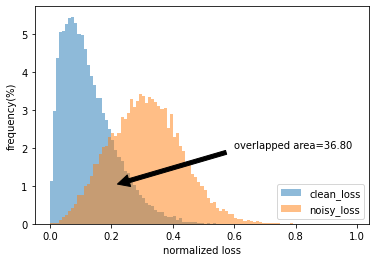

In [6]:
import tensorflow.keras.backend as K
clean_out = model1(x_train[clean_ids])
noisy_out = model1(x_train[noise_ids])
loss1 = K.categorical_crossentropy(y_train[clean_ids], clean_out)
loss2 = K.categorical_crossentropy(y_train[noise_ids], noisy_out)
loss_max, loss_min = max(max(loss1), max(loss2)), min(min(loss1), min(loss2))
loss1 = (loss1-loss_min)/(loss_max-loss_min)
loss2 = (loss2-loss_min)/(loss_max-loss_min)
ss = 0

bins = np.arange(0,1, 1e-2)
n1, bins1, patchs1 = plt.hist(loss1, bins, density=True, alpha=0.5, label='clean_loss')
n2, bins2, pathcs2 = plt.hist(loss2, bins, density=True, alpha=0.5, label='noisy_loss')
s = 0
for i in range(len(n1)):
    s += min(n2[i], n1[i])
print(s)
plt.annotate('overlapped area=%.2f'%s,xy=(0.2, 1), xytext=(0.6, 2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(loc=4)
plt.xlabel('normalized loss')
plt.ylabel('frequency(%)')
plt.show()

34.71242145440604


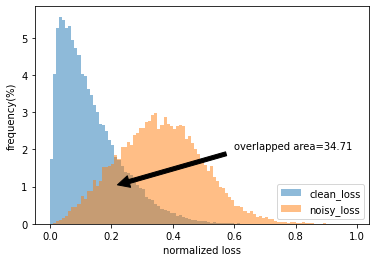

In [7]:
clean_out = model2(x_train[clean_ids])
noisy_out = model2(x_train[noise_ids])
loss1 = K.categorical_crossentropy(y_train[clean_ids], clean_out)
loss2 = K.categorical_crossentropy(y_train[noise_ids], noisy_out)
loss_max, loss_min = max(max(loss1), max(loss2)), min(min(loss1), min(loss2))
loss1 = (loss1-loss_min)/(loss_max-loss_min)
loss2 = (loss2-loss_min)/(loss_max-loss_min)
bins = np.arange(0,1, 1e-2)
bins = np.arange(0,1, 1e-2)
n1, bins1, patchs1 = plt.hist(loss1, bins, density=True, alpha=0.5, label='clean_loss')
n2, bins2, pathcs2 = plt.hist(loss2, bins, density=True, alpha=0.5, label='noisy_loss')
s = 0
for i in range(len(n1)):
    s += min(n2[i], n1[i])
print(s)
plt.annotate('overlapped area=%.2f'%s,xy=(0.2, 1), xytext=(0.6, 2), arrowprops=dict(facecolor='black', shrink=0.05))
plt.legend(loc=4)
plt.xlabel('normalized loss')
plt.ylabel('frequency(%)')
plt.show()

In [ ]:
im_model= create_model()
adam = keras.optimizers.Adam(lr=1e-4)
epochs = 100
batchsize = 128
im_model.compile(optimizer=adam, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
base_his = im_model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batchsize, verbose=2, validation_data=(x_test,to_categorical(y_test)))
import pickle
with open('mnist_ce.txt','wb') as f:
    pickle.dump(base_his.history, f)

In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.utils import to_categorical
import random
from collections import defaultdict
from sklearn.utils import shuffle
import copy
import random
import math
from matplotlib import pyplot as plt
seed = 7
np.random.seed(seed)
# def load_mnist(path):
#     with np.load(path, allow_pickle=True) as f:
#         x_train, y_train = f['x_train'], f['y_train']
#         x_test, y_test = f['x_test'], f['y_test']

#     return (x_train, y_train), (x_test, y_test)
# (x_train, y_train), (x_test, y_test) = load_mnist('../data/mnist.npz')
# num_pixels = x_train.shape[1]*x_train.shape[2]
# x_train = x_train.reshape(x_train.shape[0],num_pixels).astype('float32')
# x_test = x_test.reshape(x_test.shape[0],num_pixels).astype('float32')
# x_train = x_train/255.0
# x_test = x_test/255.0
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, y_train = shuffle(x_train,y_train, random_state=3927)
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

noise_fraction = 0.4
y_train_ori = copy.copy(y_train)
y_id = np.array([i for i in range(len(y_train))])
noise_ids = np.random.choice(y_id, int(len(y_train)*noise_fraction), replace=False)
for id in noise_ids:
    yy = y_train[id]
    ra = np.random.randint(1,10)
    yy_n = (ra+yy)%10

    y_train[id] = yy_n
clean_ids = []
for id in range(len(x_train)):
    if id in noise_ids:
        continue
    clean_ids.append(id)
y_train, y_train_ori, y_test = to_categorical(y_train), to_categorical(y_train_ori), to_categorical(y_test)

'''create_model'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
# def create_model():
#     model = keras.models.Sequential()
#     model.add(layers.Dense(num_pixels, activation='relu', input_dim=num_pixels))
#     model.add(layers.Dense(128, activation='relu'))
#     # model.add(layers.Dense(100, activation='relu'))
#     model.add(layers.Dense(10, activation='softmax'))
#     return model
'''create_model'''
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten
def create_model():
    model = keras.models.Sequential()
    model.add(Conv2D(filters=32,
                    kernel_size=(3,3),
                    input_shape=(32,32,3),
                    activation='relu',
                    padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
                    activation='relu', padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3),
                    activation='relu', padding='same'))
    # model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dropout(rate=0.50))　　　
    model.add(Dense(512, activation='relu'))
    # model.add(Dropout(rate=0.50))
    model.add(Dense(10, activation='softmax'))
    return model
def CE_MAE(y_true, y_pred):
    ce = K.categorical_crossentropy(y_true, y_pred)
    mae = K.mean(K.abs(y_true-y_pred), axis=-1)
    return ce + 2*mae
x_train, y_train, y_train_ori = shuffle(x_train, y_train, y_train_ori)

nb_epochs = 150
batchsize = 64
'''improved coteaching'''
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits = False, reduction = tf.keras.losses.Reduction.NONE)
def get_loss0(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(tf.reshape(y, (-1,1)), tf.reshape(pred_y,(-1,1)))
def focal_loss(y_true, y_pred):
   gamma = 2.0
   alpha = 0.5
   pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
   pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
   return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

def CE_L1_loss(y_true, y_pred):
    weight = 2
    ce = K.categorical_crossentropy(y_true, y_pred)
    mae = K.mean(K.abs(y_true-y_pred), axis=-1)
    return ce + weight*mae    
def get_loss1(model, x, y):
    pred_y = model(x, training=False)
    return loss_object(y_true = y, y_pred= np.array(pred_y).reshape(-1,1))
def get_loss(y_t, y_p):
    return K.categorical_crossentropy(y_t, y_p)

def loss_fn(yt, yp, ypp, ypp1, ypp2, gamma=0.5):
    # l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l1 = K.categorical_crossentropy(yt, yp)
    l2 = K.mean(K.square(ypp - (ypp1+ypp2)/2), axis=-1)
    # p1 = K.square((ypp1 + ypp2)/2)
    # p2 = K.square(1 - (ypp1 + ypp2)/2)
    # p_s = p1/(p1+p2)
    # l2 = K.square(ypp - p_s)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
def loss_fn_new(yt, yp, ypp, yppp, gamma=0.5):
    l1 = tf.losses.binary_crossentropy(tf.reshape(yt,(-1,1)), tf.reshape(yp, (-1,1)))
    l2 = K.square(ypp - yppp)
    return K.mean(l1) + gamma * K.mean(l2, axis = -1)
# model.compile(optimizer=keras.optimizers.Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
lam = 0.3

model_a = create_model()
model_b = create_model()

model_a.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])
model_b.compile(optimizer=keras.optimizers.Adam(lr=1e-4, decay=1e-4), loss=CE_L1_loss, metrics=['accuracy'])

pre_epochs = 3
x_train, y_train, y_train_ori = shuffle(x_train, y_train, y_train_ori)
# model_a.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True, verbose=2, validation_data=(x_test,y_test))
# model_b.fit(x_train, y_train, epochs=pre_epochs, batch_size=batchsize, shuffle=True, verbose=2, validation_data=(x_test,y_test))

from tqdm import tqdm
print("@@@@")
nb_batch = int(np.ceil(len(y_train) / batchsize))
optimizer_a = keras.optimizers.Adam(learning_rate=1e-4)
optimizer_b = keras.optimizers.Adam(learning_rate=1e-4)
# pre_a = model_a(x_train,training=False).numpy()
# pre_b = model_b(x_train,training=False).numpy()
# loss_a = get_loss(y_train, pre_a).numpy()
# loss_b = get_loss(y_train, pre_b).numpy()
print("!!!")

In [ ]:
cc = model_a.predict(x_train)

In [ ]:
import os
path = '../model/cifar10/3/pre_train/'
if not os.path.exists(path):
    os.mkdir(path)

In [4]:
base_model = create_model()
adam = keras.optimizers.Adam(lr=1e-4)
epochs = 100
batchsize = 128

base_model.compile(optimizer=adam, loss=keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
base_his = base_model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batchsize, verbose=2, validation_data=(x_test,to_categorical(y_test)))
import pickle
with open('ce_mae_weights/mnist_ce_60.txt','wb') as f:
    pickle.dump(base_his.history, f)

2022-12-02 17:04:37.089749: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-02 17:04:37.091058: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib
2022-12-02 17:04:37.091109: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 17:04:37.091156: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login03.chess.com): /proc/driver/nvidia/version does not exist
2022-12-02 17:04:37.091828: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F F

Epoch 1/100
391/391 - 17s - loss: 2.1797 - accuracy: 0.2253 - val_loss: 1.8007 - val_accuracy: 0.4277
Epoch 2/100
391/391 - 13s - loss: 2.0773 - accuracy: 0.2982 - val_loss: 1.6710 - val_accuracy: 0.4825
Epoch 3/100
391/391 - 13s - loss: 2.0391 - accuracy: 0.3226 - val_loss: 1.6477 - val_accuracy: 0.4923
Epoch 4/100
391/391 - 13s - loss: 2.0108 - accuracy: 0.3415 - val_loss: 1.6073 - val_accuracy: 0.5248
Epoch 5/100
391/391 - 13s - loss: 1.9885 - accuracy: 0.3534 - val_loss: 1.5332 - val_accuracy: 0.5597
Epoch 6/100
391/391 - 13s - loss: 1.9673 - accuracy: 0.3689 - val_loss: 1.5216 - val_accuracy: 0.5525
Epoch 7/100
391/391 - 13s - loss: 1.9490 - accuracy: 0.3787 - val_loss: 1.4793 - val_accuracy: 0.5946
Epoch 8/100
391/391 - 13s - loss: 1.9313 - accuracy: 0.3872 - val_loss: 1.4317 - val_accuracy: 0.5985
Epoch 9/100
391/391 - 13s - loss: 1.9169 - accuracy: 0.3952 - val_loss: 1.4275 - val_accuracy: 0.6080
Epoch 10/100


In [ ]:
import pickle
with open('mnist_base.txt','rb') as f:
    ce = pickle.load(f)
with open('mnist_mae.txt','rb') as f:
    mae = pickle.load(f)
with open('mnist_ce_10mae.txt','rb') as f:
    ce_mae = pickle.load(f)

In [ ]:
ce.keys()

In [30]:
import pickle
with open('ce_mae_weights/mnist_ce_1.txt','rb') as f:
    ce = pickle.load(f)
with open('ce_mae_weights/mnist_mae_1.txt','rb') as f:
    mae = pickle.load(f)
with open('ce_mae_weights/mnist_ce_mae_1.txt','rb') as f:
    ce_mae = pickle.load(f)
# with open('mnist_ce_10mae.txt','rb') as f:
#     ce_mae = pickle.load(f)

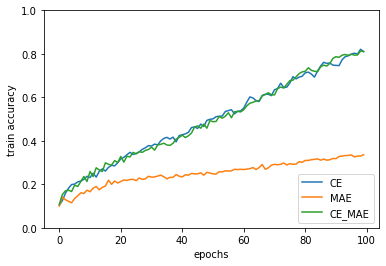

In [31]:
from matplotlib import pyplot as plt
plt.plot(ce['accuracy'], label='CE')
plt.plot(mae['accuracy'], label='MAE')
plt.plot(ce_mae['accuracy'], label='CE_MAE')
plt.legend(loc=4)
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.ylim(0,1)
plt.show()

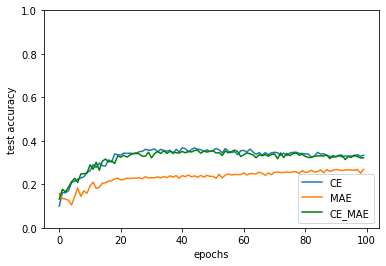

In [32]:
from matplotlib import pyplot as plt
plt.plot(ce['val_accuracy'], label='CE')
plt.plot(mae['val_accuracy'], label='MAE')
plt.plot(ce_mae['val_accuracy'], color='green', label='CE_MAE')
# plt.plot(ce['accuracy'], color='orange', linestyle='--')
# plt.plot(mae['accuracy'], color='blue', linestyle='--')
# plt.plot(ce_mae['accuracy'], color='green', linestyle='--')
plt.legend(loc=4)
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.ylim(0,1)
plt.show()

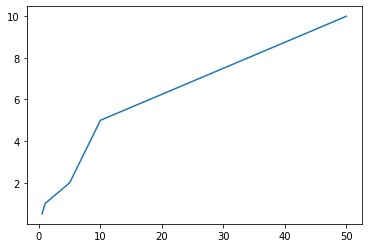

In [18]:
xxx = [0.5, 1, 5, 10, 50]
yyy = [0.5, 1, 2, 5, 10]
plt.plot(xxx, yyy)
plt.show()

In [ ]:
mm = create_model()
mm.compile(optimizer='adam', loss=keras.losses.MeanAbsoluteError(), metrics=['accuracy'])
aa = mm(x_train)
print(aa.shape)

In [ ]:
cc = mm.evaluate(x_train,y_train)

In [23]:
path = '../model/cifar10/old/1/pre_train/'
val_acc = np.load(path+'val_acc_100.npy')
acc = np.load(path+'acc_100.npy')
cr = np.load(path+'clean_rate_100.npy')

In [24]:
aa = val_acc[-1]

In [25]:
# aa = aa/4
print(aa)

0.623199999332428


In [28]:
path0 = '../model/cifar10/2/lam_0.3/'
val_acc0 = np.load(path0+'val_acc_100.npy')
acc0 = np.load(path0+'acc_100.npy')
cr0 = np.load(path0+'clean_rate_100.npy')

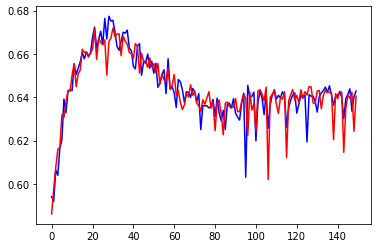

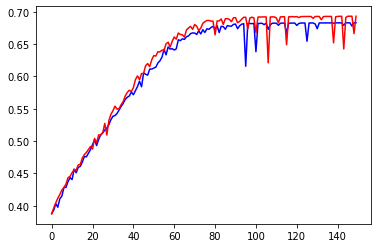

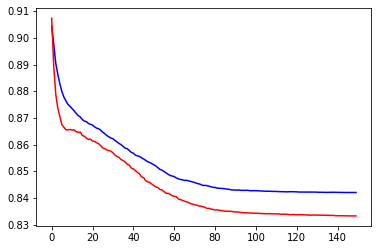

In [21]:
plt.plot(val_acc, color='b')
plt.plot(val_acc0, color='r')
plt.show()
plt.plot(acc, color='b')
plt.plot(acc0, color='r')
plt.show()
plt.plot(cr, color='b')
plt.plot(cr0, color='r')
plt.show()

In [ ]:
print(val_acc[-1], acc[-1])

In [ ]:
aaa = np.array([0.6315,0.6329, 0.6412])
print(aaa.mean(), aaa.std())

In [ ]:
print(val_acc[-1])

In [ ]:
plt.plot(val_acc)
plt.plot(acc)
plt.plot(cr)
plt.show()

In [ ]:
print(type(yyy_one))
ddd = np.argmax(yyy_one,axis=-1)

In [ ]:
np.save('../model/cifar10/test.npy', ddd)

In [ ]:
print(type(cc))

In [ ]:
bb = aa/K.sum(aa, axis=-1,keepdims=True)

In [ ]:
print(aa[:5])
print(K.sum(aa, axis=-1)[:5])
print(bb[:5])

In [ ]:
mae_model = create_model()
adam = keras.optimizers.Adam(lr=1e-4)
epochs = 100
batchsize = 128
mae_model.compile(optimizer=adam, loss=keras.losses.MeanAbsoluteError(), metrics=['accuracy'])
mae_his = mae_model.fit(x_train, to_categorical(y_train), epochs=epochs, batch_size=batchsize, verbose=2, validation_data=(x_test,to_categorical(y_test)))
import pickle
with open('mnist_mae.txt','wb') as f:
    pickle.dump(mae_his.history, f)